In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import json

from sorbetto.core.entity import Entity
from sorbetto.ranking.ranking_score import RankingScore
from sorbetto.performance.two_class_classification_performance import TwoClassClassificationPerformance
from sorbetto.parameterization.parameterization_default import ParameterizationDefault
from sorbetto.analysis.analysis_app_developer import AnalysisForAppDeveloper

# How to use the tile: Application Developper guide

## App developper

The application developer is interested in selecting the best
method that aligns with the specific requirements of his/her
application. This developer may already know the importance of true positives, false positives, false negatives, and
true negatives relevant to a particular use case. The goal is
therefore to choose a method that best meets these predefined criteria.

For more information, please refer to the  [*reference paper*](https://arxiv.org/abs/2412.04377).

The app developper may encounter three distinct situations:
- In the first case, the importancevalues are known.
- In the second case, the importance values are unknown but can be determined by analyzing the community practices.
- In the last case, there is no information on the importance values.

### Data

In this example, the list of entities are the different deep learning models from mmsegmentation that are obtained on cityscape data.

In [7]:
# loading data


PATH_DATA = os.path.join(os.getcwd(), 'data', 'semantic_segmentation_methods.json')

MAP_DATASETS = {
    'Cityscapes': '♠',
    'ADE20K': '♥',
    'Pascal VOC 2012': '♦',
    'COCO-Stuff 164k': '♣'
}

def get_colors ( num_colors ) :
    x = np.linspace ( 0.0 , 1.0 , num_colors )
    a = np.floor ( x * x * np.sqrt ( num_colors ) )
    v = 1.0 - a / ( np.max ( a ) + 1 )
    h = x * x * ( np.max ( a ) + 1 )
    h = h - np.floor ( h )
    hsv = np.ones ( [num_colors,3] )
    hsv [:,0] = h
    hsv [:,1] = v
    hsv [:,2] = 1.0
    rgb = hsv_to_rgb( hsv )
    rgba = np.ones ( [num_colors,4] )
    rgba [:,0:3] = rgb
    return rgba

def read_json(filePath:str):
    """
    Function to read json 
    """
    
    with open(filePath, 'r') as f:
        data = json.load(f)
    return data


def read_data(filePath:str = PATH_DATA):
    data = read_json(filePath)

    processed_data = []

    colors = get_colors(len(data))

    # convert each instance into an Entity
    for i, elem in enumerate(data):
        performance = TwoClassClassificationPerformance(
            ptp=elem['proba_tp'],
            ptn=elem['proba_tn'],
            pfp=elem['proba_fp'],
            pfn=elem['proba_fn']
        )

        entity = Entity(
            performance= performance,
            name = f"{elem['model']} {MAP_DATASETS[elem['learning_set']]}",
            color= colors[i]
        )

        processed_data.append(entity)

    return processed_data

data = read_data()

In [8]:
params = ParameterizationDefault()

analysis = AnalysisForAppDeveloper(
    entities=data,
    parameterization=params
)

## Case 1: Known importance

In this case, it is possible to select the best method at the wanted position and observe the associated score.

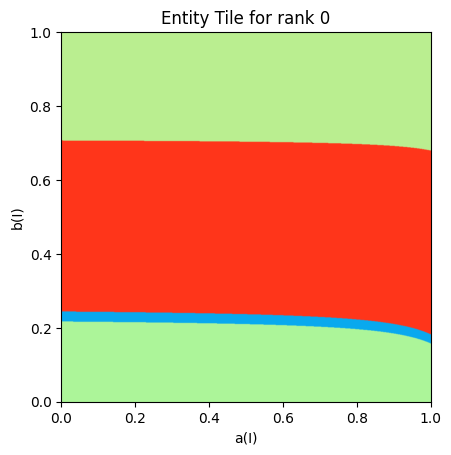

In [9]:
# Observing which entity is the best at a given score.

entity_tile = analysis.getEntityTile(0)
entity_tile.draw()
plt.show()

Let's say we desire the best performance for the accuracy (a = 0.5, b= 0.5). It is possible to get the entity that is best at that specific score.

In [10]:
pt = params.locateAccuracy()
a_id = np.argmin(np.abs(entity_tile._vec_x - pt.x))
b_id = np.argmin(np.abs(entity_tile._vec_y - pt.y))

id_list = entity_tile.mat_value[a_id, b_id]
best_entity_accuracy = data[id_list]

print(f"The best entity for the accuracy is {best_entity_accuracy.name} at id {id_list}")

The best entity for the accuracy is SETR ♠ at id 68


It is then possible to observe the value tile of the associated entity and observe how well it will perform in different scenarios.

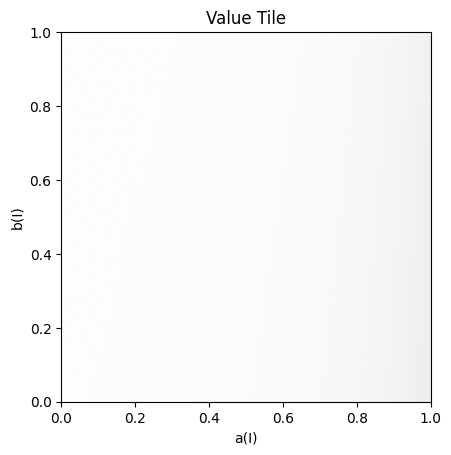

In [11]:
value_tile = analysis.getValueTile(best_entity_accuracy)
value_tile.draw()
plt.show()
#TODO code: fix draw

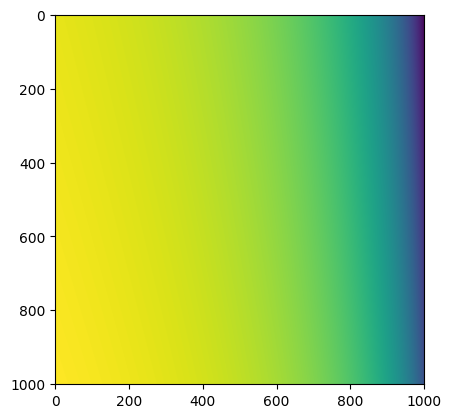

In [12]:
mat = value_tile.mat_value
plt.imshow(mat)
plt.show()

## Case 2: Unknown importance but known score

Some score are not in the tile. If such a score is wanted, it is possible to use a correlation tile to observe which score is the closest in the tile and use this one to get back to case 1.

100%|██████████| 1001/1001 [03:25<00:00,  4.86it/s]


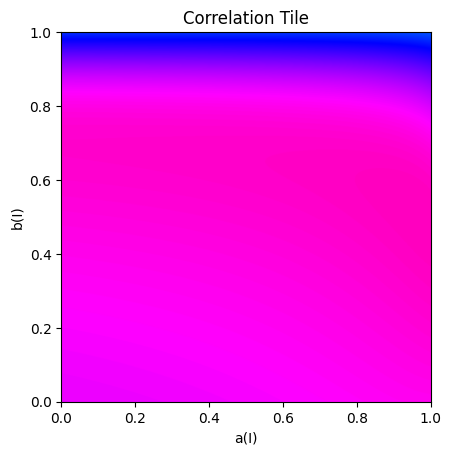

In [13]:
#TODO same code as in the score_correlation notebook.
from sorbetto.core.importance import Importance

def cohen_kappa(importance: Importance):

    tp = importance.ptp
    tn = importance.ptn
    fp = importance.pfp
    fn = importance.pfn

    num = 2*(tp*tn - fp*fn)
    den = (tp + fn)*(tn + fn) + (tp + fp)*(fp + tn)
    return num / den


correlation_tile = analysis.getCorrelationTile(correlation_fct = 'pearsonr', score = cohen_kappa)
correlation_tile.draw()
plt.show()

In [ ]:
# find the most correlated canonical ranking score
flat_index = np.argmax(correlation_tile.mat_value)

# Convert the flat index to 2D coordinates (i, j)
i, j = np.unravel_index(flat_index, correlation_tile.mat_value.shape)

a = correlation_tile._mat_x[i, j]
b = correlation_tile._mat_y[i, j]
importances = correlation_tile.importances[i, j]
corr_val = correlation_tile.mat_value[i,j]

print(f"The most correlated score is at a = {a}, b = {b}\n The associated importance is {importances}\n The correlation value is {corr_val}")

The most correlated score is at a = 0.98, b = 0.5
 The associated importance is [0.02 0.5  0.5  0.98]
 The correlation value is 0.9999998936725804


In [39]:
# perform a similar analysis as before with this new score

id_list = entity_tile.mat_value[i, j]
best_entity_accuracy = data[id_list]

print(f"The best entity for the accuracy is {best_entity_accuracy.name} at id {id_list}")

The best entity for the accuracy is SETR ♠ at id 68


## Case 3: No knowledge

In such a case, it is necessary to rely on more generic selection criterion. One selection mechanism consists in minimizing the maximum rank over the Ranking Tile and, in case of ex aequo, minimizing the average rank.

In [14]:
# TODO

## Advice

In [15]:
#TODO